In [1]:
import sys, os
import theano
import scipy
from collections import OrderedDict
from copy import deepcopy
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams
import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions import Interpolated
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')
from tqdm import tqdm
from collections import Counter
import scanpy as sc
import pandas as pd
sc.settings.autosave=False
sc.settings.autoshow=True
import anndata
import re


In [2]:
adatapaths=['/home/mt/Downloads/1k_hgmm','/scrapp2/mtschmitz/5k_pbmc_v3','/scrapp2/mtschmitz/E40_motor_Out','E50_motor_Out','E65_motor_Out','E80motor_Out','E100motor_Out']
genomenames=['','',"refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel",
            "refdata-celranger-mmul8-toplevel","refdata-celranger-mmul8-toplevel"]
samplenames=['1kHGMM','5kPCMB','E40','E50','E65','E80','E100']
adatapath=adatapaths[0]
#genomename="refdata-celranger-mmul8-toplevel"
genomename=''
samplename=samplenames[0]

In [3]:
print(samplename, flush=True)
maxgenes=4000
n_iterations=100
#Number of topics, not including ambient topic
K=10
subtractive=False
sc.settings.figdir=os.path.expanduser('~/figs/'+str(subtractive)+'/'+samplename)
if not os.path.exists(sc.settings.figdir):
        os.makedirs(sc.settings.figdir)

adata = sc.read_10x_mtx(os.path.join(adatapath,'outs/raw_feature_bc_matrix'),cache=True)
bcs=list(pd.read_csv(os.path.join(adatapath,'outs/filtered_feature_bc_matrix','barcodes.tsv.gz')).iloc[:,0])
#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
sc.pp.filter_genes(adata, min_cells=10,inplace=True)
sc.pp.filter_cells(adata,min_counts=1,inplace=True)
plt.close()
sns.distplot(np.log10(adata.X.sum(1).A1),kde=False)
plt.savefig(os.path.join(sc.settings.figdir,'DropCountsHist.png'))
plt.close()
sc.pp.filter_cells(adata,min_counts=15,inplace=True)
adata=adata[adata.obs.n_counts.argsort(),:]

adata.var_names_make_unique()
freshadata=adata.copy()
print('original shape',freshadata.shape)
cell_inds=np.where([x in bcs for x in adata.obs.index])[0]
junk_inds=np.where([x not in bcs for x in adata.obs.index])[0]

ambient_counts=np.log10(adata[[x not in bcs for x in adata.obs.index] ,:].X.sum(1).A1)
adata._inplace_subset_var((-adata[junk_inds,:].X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])
phiAmbient = adata[junk_inds,:].X.sum(axis=0)/adata[junk_inds,:].X.sum(axis=1).sum()
phiAmbientDict=dict(zip(list(adata.var.index), phiAmbient.A1))
adata._inplace_subset_obs(cell_inds)
freshadata._inplace_subset_obs(cell_inds)

feature_names=list(adata.var.index)
tf=adata.X
n_tokens = np.sum(tf[tf.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(tf.nonzero()[0]) / float(tf.shape[0] * tf.shape[1])))



1kHGMM


Trying to set attribute `.var` of view, making a copy.


original shape (77770, 26344)
Number of tokens in training set = 26029622.0
Sparsity = 0.3847945013979497


1073 4000
Ambient Mean 1.6355431
Ambient STD 0.14536236
l __str__ = -270.0499167118687
l __str__ = -5509.6389139360945
l __str__ = -72990.28200345272
l __str__ = -205149360.7132973
l __str__ = 26029624.0
l __str__ = []
sub __str__ = -231178984.7132973
sub __str__ = -74063.28200345272
div __str__ = -7.8813801041957925
div __str__ = -68.0244939454359
l __str__ = -270.0499167118687
l __str__ = -5509.6389139360945
l __str__ = -72990.28200345272
l __str__ = -205149360.7132973
l __str__ = 26029624.0
l __str__ = []
sub __str__ = -231178984.7132973
sub __str__ = -74063.28200345272
div __str__ = -7.8813801041957925
div __str__ = -68.0244939454359
l __str__ = -270.0499167118687
l __str__ = -5509.6389139360945
l __str__ = -72990.28200345272
l __str__ = -205149360.7132973
l __str__ = 26029624.0
l __str__ = []
sub __str__ = -231178984.7132973
sub __str__ = -74063.28200345272
div __str__ = -7.8813801041957925
div __str__ = -68.0244939454359


Average Loss = 1.6977e+08:  22%|██▏       | 448/2000 [14:10<49:45,  1.92s/it]
Interrupted at 448 [22%]: Average Loss = 1.6973e+08


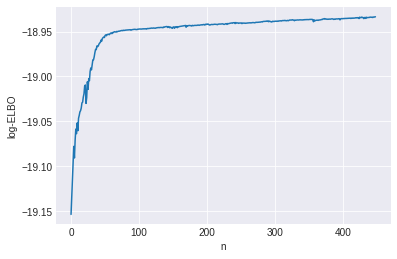

In [4]:
model1 = pm.Model()
(D,V)=tf.shape
print(D,V)
alpha = np.ones((D, K))*.1
alpha[:,K-1]=np.mean(ambient_counts)/tf.sum(1).A1
#beta prior for gene over topic distribution
beta = np.ones((K-1, V))*.1
sparse_array=shared(np.array([tf.nonzero()[0],tf.nonzero()[1],tf.data]).T.astype('int32'))
tt.cast(sparse_array,'int32')
rowsums=shared(np.sum(tf,axis=1).T)
sumall=shared(np.sum(tf))
print("Ambient Mean",np.mean(ambient_counts), flush=True)
print("Ambient STD",np.std(ambient_counts), flush=True)
def lognormpdf(mean, sd):
    import math
    def internalnorm(x):
        var = float(sd)**2
        denom = tt.log(2*math.pi*var)*.5
        num = -(x-float(mean))**2/(2*var)
        return(num-denom)
    return internalnorm
ambient=lognormpdf(np.mean(ambient_counts),np.std(ambient_counts))

def _norm_logpdf(x):
    _norm_pdf_logC=tt.log(tt.sqrt(2*np.pi))
    return -x**2 / 2.0 - _norm_pdf_logC

def lognormpdf(mean, sd,df):
    import math
    def internalnorm(x):
        df2=x.shape[1]-1
        sd2=x.std()
        Fstat=sd2/sd
        n = 1.0 * df
        m = 1.0 * df2
        lPx = m/2 * tt.log(m) + n/2 * tt.log(n) + (n/2 - 1) * tt.log(Fstat)
        lPx -= ((n+m)/2) * np.log(m + n*Fstat) + (tt.gammaln(n/2)+tt.gammaln(m/2)-tt.gammaln((n+m)/2))
        tt.printing.Print('l')(lPx)
        #fp=scipy.stats.f.logpdf(Fstat,df,df2)
        pooledSE = tt.sqrt(sd**2/df + sd2**2/df2)
        z = (tt.mean(x)-mean)/pooledSE
        pval = _norm_logpdf(z)
        tt.printing.Print('l')(pval)
        var = float(sd)**2
        denom = tt.log(2*math.pi*var)*.5
        num = -(x-float(mean))**2/(2*var)
        return(lPx+pval+tt.sum(num-denom))
    return internalnorm
ambient=lognormpdf(np.mean(ambient_counts),np.std(ambient_counts),len(ambient_counts)-1)


def log_lda(theta, phi,value,rowsums,sumall,phiAmbient=None):
    if phiAmbient is not None:
        phi=tt.concatenate([phi,phiAmbient],axis=0)
    else:
        phi=phi
    #ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-9)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-9),axis=1).ravel()                                                                  
    #ambientll=ambient(tt.log10((rowsums)*(theta[:,theta.shape[1]-1])+1e-9))
    ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-10)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-10),axis=1).ravel()                                                                  
    ambientll=ambient(tt.log10((rowsums+1e-10)*(theta[:,theta.shape[1]-1]+1e-10)))
    tt.printing.Print('l')(tt.sum(ambientll))
    tt.printing.Print('l')(tt.sum(ll))
    tt.printing.Print('l')(sumall)
    tt.printing.Print('l')(ambientll.shape)
    tt.printing.Print('sub')((tt.sum(ll)-sumall))
    tt.printing.Print('sub')(tt.sum(ambientll)-rowsums.shape[1])
    tt.printing.Print('div')((tt.sum(ll)/sumall))
    tt.printing.Print('div')(tt.sum(ambientll)/rowsums.shape[1])
    #return((ambientll.shape[1]*(tt.sum(ll)/sumall) + (tt.sum(ambientll))))
    #return tt.sum(ll) + tt.sum(ambientll)*(sumall/rowsums.shape[1])
    return(tt.sum(ll)+ambientll)
    #return((1e6*(tt.sum(ll)/sumall) + (tt.sum(ambientll)/ambientll.shape[1])*3e3))
    #return (tt.sum(ll)-sumall) + (tt.sum(ambientll)-rowsums.shape[1])

with model1: 
    theta = pm.Dirichlet("theta", a=alpha, shape=(D, K), transform=t_stick_breaking(1e-9))#.astype('float32')
    #Kth topic is fixed as ambient distribution, therefore not learned
    phi = pm.Dirichlet("phi", a=beta, shape=(K-1, V), transform=t_stick_breaking(1e-9))#.astype('float32')
    doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta,
        phi=phi,
        value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))    
eta = .3
s = shared(eta)
def reduce_rate(a, h, i):
    s.set_value(eta/((i+1)/100)**.4)   
    
with model1:    
    #inference = pm.ADVI()
    #inference = pm.FullRankADVI()
    inference=pm.variational.NFVI()
    approx = pm.fit(n=2000,method=inference,obj_optimizer=pm.adam(learning_rate=s))#,callbacks=[reduce_rate])


tr1 = approx.sample(draws=1000)
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(approx.hist),
     'n': np.arange(approx.hist.shape[0])})
plt.clf()
sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
plt.savefig(os.path.join(sc.settings.figdir,'ELBO.png'))
theta=tr1['theta'].mean(0)
theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
for i in range(theta.shape[1]):
    freshadata.obs['lda_'+str(i)]=theta[:,i].X

# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))

for i in range(phi.shape[0]):
    freshadata.var['lda_'+str(i)]=0
    freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(i)]=phi[i,:][:,list(phiAmbientDict.keys())].X
freshadata.var['lda_'+str(K-1)]=0
#Resort indices so the ones we're subtracting from are listed first
freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(K-1)]=list(phiAmbientDict.values())
fullinds=list(freshadata.var.index)
[fullinds.insert(0, fullinds.pop(fullinds.index(i))) for i in feature_names[::-1]]
freshadata=freshadata[:,fullinds]
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
#phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    

In [5]:
adata.var['Mouse'] = ['mm10' in x for x in adata.var.index]
adata.obs['PercentM'] =adata[:,list(adata.var['Mouse'])].X.sum(1)/adata.X.sum(1)
adata.obs['Mcounts'] =adata[:,list(adata.var['Mouse'])].X.sum(1)
adata.obs['Hcounts'] =adata[:,list(np.invert(adata.var['Mouse']))].X.sum(1)
freshadata.var['Mouse'] = ['mm10' in x for x in freshadata.var.index]
freshadata.obs['PercentM'] =freshadata[:,list(freshadata.var['Mouse'])].X.sum(1)/freshadata.X.sum(1)
freshadata.obs['Mcounts'] =freshadata[:,list(freshadata.var['Mouse'])].X.sum(1)
freshadata.obs['Hcounts'] =freshadata[:,list(np.invert(freshadata.var['Mouse']))].X.sum(1)


Trying to set attribute `.var` of view, making a copy.


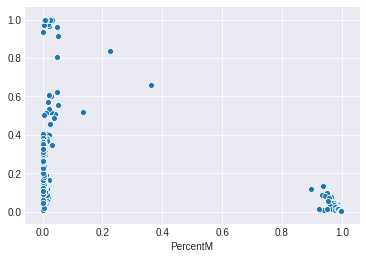

[[1.         0.42467315]
 [0.42467315 1.        ]]
[[1.         0.97427179]
 [0.97427179 1.        ]]


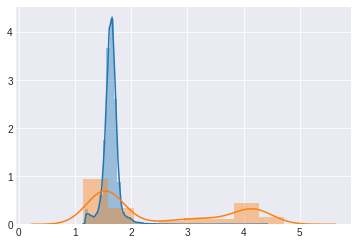

In [6]:
sns.scatterplot(adata.obs['PercentM'],theta[:,9].X)
plt.show()
humanmousegenes=adata[adata.obs['PercentM']<.2,][:,adata.var['Mouse']]
print(np.corrcoef( humanmousegenes.X.sum(0) ,[phiAmbientDict[i] for i in humanmousegenes.var.index]))
mousehumangenes=adata[adata.obs['PercentM']>.8,][:,np.invert(adata.var['Mouse'])]
print(np.corrcoef( mousehumangenes.X.sum(0) ,[phiAmbientDict[i] for i in mousehumangenes.var.index]))
sns.distplot(ambient_counts)
sns.distplot(np.log10(adata.X.sum(1).A1*theta[:,9].X))


[[1.         0.45140358]
 [0.45140358 1.        ]]
[[1.         0.45140358]
 [0.45140358 1.        ]]
[[1.         0.97356855]
 [0.97356855 1.        ]]


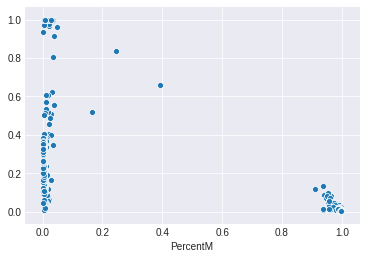

In [7]:
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].X)
humanmousegenes=freshadata[freshadata.obs['PercentM']<.2,][:,freshadata.var['Mouse']]
print(np.corrcoef( humanmousegenes.X.sum(0) ,[phiAmbientDict[i] for i in humanmousegenes.var.index]))
print(np.corrcoef( humanmousegenes.X.sum(0).A1 ,humanmousegenes.var['lda_9']))
mousehumangenes=freshadata[freshadata.obs['PercentM']>.8,][:,np.invert(freshadata.var['Mouse'])]
print(np.corrcoef( mousehumangenes.X.sum(0) ,[phiAmbientDict[i] for i in mousehumangenes.var.index]))


In [8]:
mats=[]

In [9]:
#subtractive corrected countz numerator
tmpmat3=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    rowtxpamb=(theta[ci,(K-1)]*phi[:,(K-1)].T).A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = np.array([item for sublist in indmultiset for item in sublist])
    phimultiset=[[rowtxpamb[rowind]/countz[i]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = np.array([item for sublist in phimultiset for item in sublist])
    phimultiset=[[rowtxp[rowind]+rowtxpamb[rowind]+1e-10]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvalsdenom = np.array([item for sublist in phimultiset for item in sublist])
    pvals=pvals/(pvalsdenom)
    vals=vals[pvals>0]
    pvals=pvals[pvals>0]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[ci,theta.shape[1]-1]*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat3[ci,list(countremove.keys())]=list(countremove.values())




1073it [02:06,  2.76it/s]


[[1.         0.45171397]
 [0.45171397 1.        ]]
[[1.         0.83058179]
 [0.83058179 1.        ]]


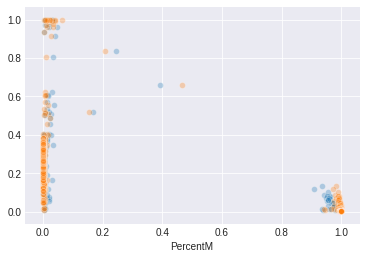

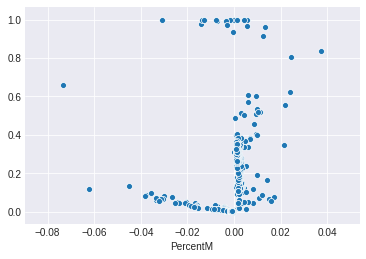

In [10]:
print(np.corrcoef(tmpmat3.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
newmat=freshadata.X-tmpmat3
mats.append(newmat)
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
print(np.corrcoef(newmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].A1,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1,alpha=.3)
plt.show()
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1)
plt.show()

In [11]:
#additive
tmpmat=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    phimultiset=[[rowtxp[rowind]/countz[i]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int((1-theta[ci,(K-1)])*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat[ci,list(countremove.keys())]=list(countremove.values())
ambmat=freshadata.X-tmpmat
mats.append(tmpmat)

1073it [01:35,  4.36it/s]


In [12]:
print(np.corrcoef(tmpmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
print(np.corrcoef(ambmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
print(np.corrcoef(freshadata.X.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
print(np.corrcoef(freshadata.var['lda_9'],[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)


[[1.         0.80512729]
 [0.80512729 1.        ]]
[[1.         0.84492715]
 [0.84492715 1.        ]]
[[1.         0.84602116]
 [0.84602116 1.        ]]
[[1. 1.]
 [1. 1.]]


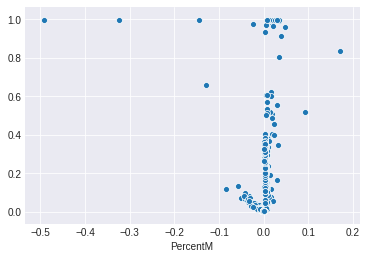

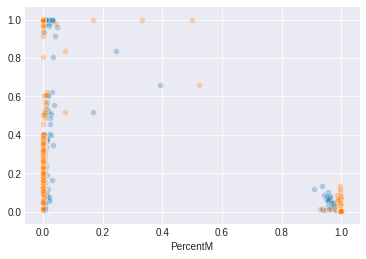

In [13]:
newmat=tmpmat
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].A1,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1,alpha=.3)


In [ ]:
#additive without countz
tmpmat=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    phimultiset=[[rowtxp[rowind]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int((1-theta[ci,(K-1)])*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat[ci,list(countremove.keys())]=list(countremove.values())
ambmat=freshadata.X-tmpmat
mats.append(tmpmat)

In [ ]:
print(np.corrcoef(tmpmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
print(np.corrcoef(ambmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)


In [ ]:
newmat=tmpmat
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].A1,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1,alpha=.3)


In [ ]:
#Subtractive with countz correction
theta=tr1['theta'].mean(0)
theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
#phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    

tmpmat2=scipy.sparse.csr_matrix(freshadata.shape)
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    #phimultiset=[[phiAmbientDict[rowname]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    phimultiset=[[phiAmbientDict[rowname]/countz[i]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[c,theta.shape[1]-1].X*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat2[ci,list(countremove.keys())]=list(countremove.values())


In [ ]:
print(np.corrcoef(tmpmat2.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
plt.close()
newmat=freshadata.X-tmpmat2
mats.append(newmat)
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].X)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].X,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].X,alpha=.3)


In [ ]:
#Subtractive Without countz balance
theta=tr1['theta'].mean(0)
theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
#phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    

tmpmat2=scipy.sparse.csr_matrix(freshadata.shape)
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    #phimultiset=[[phiAmbientDict[rowname]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    phimultiset=[[phiAmbientDict[rowname]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[c,theta.shape[1]-1].X*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat2[ci,list(countremove.keys())]=list(countremove.values())


In [ ]:
print(np.corrcoef(tmpmat2.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
plt.close()
newmat=freshadata.X-tmpmat2
mats.append(newmat)
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].X)
plt.show()
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].X,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].X,alpha=.3)


In [ ]:
#subtractive nocountz
tmpmat4=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    rowphi=phi[ci,:].A1
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    phimultiset=[[rowphi[K-1]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = np.array([item for sublist in phimultiset for item in sublist])
    phimultiset=[[rowtxp[rowind]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvalsdenom = np.array([item for sublist in phimultiset for item in sublist])
    pvals=pvals/(pvals+pvalsdenom)
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[ci,theta.shape[1]-1]*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat4[ci,list(countremove.keys())]=list(countremove.values())




In [ ]:
print(np.corrcoef(tmpmat4.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
newmat=freshadata.X-tmpmat4
mats.append(newmat)
newmat[:,list(freshadata.var['Mouse'])].sum(1)/newmat.sum(1)
print(np.corrcoef(newmat.sum(0),[phiAmbientDict[i] for i in freshadata.var.index]), flush=True)
sns.scatterplot(freshadata.obs['PercentM'],theta[:,9].A1,alpha=.3)
sns.scatterplot(newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1,alpha=.3)
plt.show()
sns.scatterplot(freshadata.obs['PercentM']-newmat[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/newmat.sum(1).A1,theta[:,9].A1)

In [ ]:
absols=[]
for m in mats:
    pm=m[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/m.sum(1).A1
    m=m[(pm>.85) | (pm<.13),:]
    absol=np.absolute(.5-(m[:,np.where(list(freshadata.var['Mouse']))[0]].sum(1).A1/m.sum(1).A1))
    sns.scatterplot(theta[(pm>.85) | (pm<.13),9].A1,absol)
    plt.show()
    #sns.distplot(absol,kde=False)
    #plt.show()
    absols.append(np.mean(absol))
    print(np.median(absol))

# multiseq test

In [3]:
maxgenes=1000
ncells=500
headpath=os.path.expanduser("/home/mt/Downloads/")
adata=sc.read_h5ad(os.path.join(headpath,'MultiseqRaw.h5ad'))
adata._inplace_subset_obs(adata.obs['batch']=='0')
cells=np.random.choice(adata.obs.index,ncells,replace=False)
sc.pp.filter_cells(adata,min_counts=15,inplace=True)
adata._inplace_subset_obs(cells)
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=min(maxgenes,4000))
sc.pp.scale(adata, max_value=10)
#sc.pp.regress_out(adata,'n_counts')

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
clusters=adata.obs['leiden']

/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [4]:
headpath=os.path.expanduser("/home/mt/Downloads/")
adata=sc.read_h5ad(os.path.join(headpath,'MultiseqRaw.h5ad'))
adata._inplace_subset_obs(cells)
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])
adata.obs['leiden']=clusters
freshadata=adata.copy()

In [5]:
ambmu,ambsd=2.0,.4
K=10
n_iterations=120

In [10]:
clusterphis=[]
for c in set(clusters):
    clusterphis.append(adata[adata.obs['leiden']==c,:].X.sum(0).A1)
clusterphis=np.matrix(clusterphis)
clusterphis=clusterphis/(clusterphis.sum(1))

def Stick_Breaking(num_weights, alpha):
    betas = np.random.beta(1, alpha, size=num_weights)
    betas[1:] *= np.cumprod(1 - betas[:-1])
    return betas
ambprops=Stick_Breaking(len(set(clusters)),1)
np.random.shuffle(ambprops)
ambcounts=[int(x) for x in 10**np.random.normal(ambmu,ambsd,adata.shape[0])]
print(ambprops)
sum(ambprops)


[0.00070446 0.14045108 0.00093247 0.0190335  0.00159163 0.69986101
 0.0909612  0.04575703]


0.999292384641271

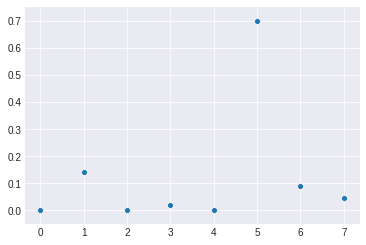

In [11]:
sns.scatterplot(list(range(len(ambprops))),ambprops)

In [12]:
phiAmbient=(ambprops*clusterphis).A1
phiAmbient=phiAmbient/phiAmbient.sum()
phiAmbientDict=dict(zip(list(adata.var.index), phiAmbient))
tmpmat=scipy.sparse.csr_matrix(adata.shape)
for ci,c in tqdm(enumerate(adata.obs.index)):
    countadd=Counter(np.random.choice(list(range(len(phiAmbient))),replace=True,size=ambcounts[ci],p=phiAmbient))
    tmpmat[ci,list(countadd.keys())]=list(countadd.values())

500it [00:00, 1214.21it/s]


In [81]:
adata.X.sum()

1096647.0

In [9]:
adata.X=adata.X+tmpmat

In [80]:
(adata.X-tmpmat).sum()

1026670.0

In [11]:
np.corrcoef(tmpmat.sum(0).A1,phiAmbient)

array([[1.        , 0.99920635],
       [0.99920635, 1.        ]])

In [69]:
feature_names=list(adata.var.index)
tf=adata.X
n_tokens = np.sum(tf[tf.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(tf.nonzero()[0]) / float(tf.shape[0] * tf.shape[1])))

model1 = pm.Model()
(D,V)=tf.shape
print(D,V)
alpha = np.ones((1, K))*1
beta = np.ones((1, V))*1
sparse_array=shared(np.array([tf.nonzero()[0],tf.nonzero()[1],tf.data]).T.astype('int32'))
tt.cast(sparse_array,'int32')
rowsums=shared(np.sum(tf,axis=1).T)
sumall=shared(np.sum(tf))
def lognormpdf(mean, sd):
    import math
    def internalnorm(x):
        var = float(sd)**2
        denom = tt.log(2*math.pi*var)*.5
        num = -(x-float(mean))**2/(2*var)
        return(num-denom)
    return internalnorm
ambient=lognormpdf(ambmu,ambsd)


def log_lda(theta, phi,value,rowsums,sumall,phiAmbient=None):
    if phiAmbient is not None:
        phi=tt.concatenate([phi,phiAmbient],axis=0)
    else:
        phi=phi
    #ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-9)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-9),axis=1).ravel()                                                                  
    #ambientll=ambient(tt.log10((rowsums)*(theta[:,theta.shape[1]-1])+1e-9))
    ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-10)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-10),axis=1).ravel()                                                                  
    ambientll=ambient(tt.log10((rowsums+1e-10)*(theta[:,theta.shape[1]-1]+1e-10)))
    tt.printing.Print('l')(tt.sum(ambientll))
    tt.printing.Print('l')(tt.sum(ll))
    tt.printing.Print('l')(sumall)
    tt.printing.Print('l')(ambientll.shape[1])
    tt.printing.Print('sub')((tt.sum(ll)-sumall))
    tt.printing.Print('sub')(tt.sum(ambientll)-rowsums.shape[1])
    tt.printing.Print('div')((tt.sum(ll)/sumall))
    tt.printing.Print('div')(tt.sum(ambientll)/rowsums.shape[1])
    #return((ambientll.shape[1]*(tt.sum(ll)/sumall) + (tt.sum(ambientll))))
    #return tt.sum(ll) + tt.sum(ambientll)*(sumall/rowsums.shape[1])
    #return(tt.sum(ll)+ tt.sum(ambientll))
    return((1e6*(tt.sum(ll)/sumall) + (tt.sum(ambientll)/ambientll.shape[1])*1e4))
    #return (tt.sum(ll)-sumall) + (tt.sum(ambientll)-rowsums.shape[1])

with model1: 
    theta = pm.Dirichlet("theta", a=alpha, shape=(D, K), transform=t_stick_breaking(1e-9))#.astype('float32')
    #Kth topic is fixed as ambient distribution, therefore not learned
    phi = pm.Dirichlet("phi", a=beta, shape=(K-1, V), transform=t_stick_breaking(1e-9))#.astype('float32')
    doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta,
        phi=phi,
        value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))
eta = .3
s = shared(eta)
def reduce_rate(a, h, i):
    s.set_value(eta/((i/10)+1)**.4) 

Number of tokens in training set = 1096647.0
Sparsity = 0.493286
500 1000
l __str__ = -215.52462357086821
l __str__ = -7098750.282865145
l __str__ = 1096647.0
l __str__ = 500
sub __str__ = -8195397.282865145
sub __str__ = -715.5246235708682
div __str__ = -6.473140657718615
div __str__ = -0.4310492471417364
l __str__ = -215.52462357086821
l __str__ = -7098750.282865145
l __str__ = 1096647.0
l __str__ = 500
sub __str__ = -8195397.282865145
sub __str__ = -715.5246235708682
div __str__ = -6.473140657718615
div __str__ = -0.4310492471417364
l __str__ = -215.52462357086821
l __str__ = -7098750.282865145
l __str__ = 1096647.0
l __str__ = 500
sub __str__ = -8195397.282865145
sub __str__ = -715.5246235708682
div __str__ = -6.473140657718615
div __str__ = -0.4310492471417364


In [70]:
with model1:    
    #inference = pm.ADVI()
    #inference = pm.FullRankADVI()
    inference=pm.variational.NFVI()
    approx = pm.fit(n=200,method= inference,obj_optimizer=pm.adam(learning_rate=s),callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])


Average Loss = 5.6418e+06: 100%|██████████| 200/200 [00:37<00:00,  5.61it/s]
Finished [100%]: Average Loss = 5.6371e+06


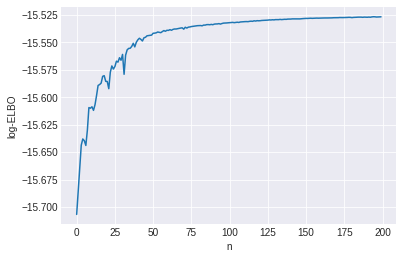

-0.05214897453075936


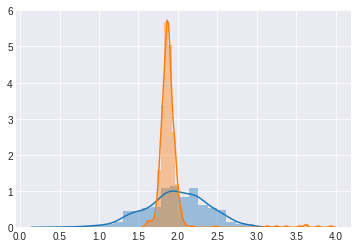

Trying to set attribute `.obs` of view, making a copy.


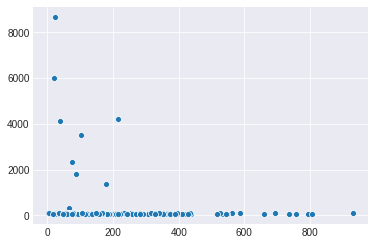

In [71]:

tr1 = approx.sample(draws=500)
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(approx.hist),
     'n': np.arange(approx.hist.shape[0])})
plt.clf()
sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
plt.savefig(os.path.join(sc.settings.figdir,'ELBO.png'))
plt.show()
theta=tr1['theta'].mean(0)
#plot 
print(np.corrcoef(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9]))[0,1])
sns.distplot(np.log10(ambcounts))
sns.distplot(np.log10(adata.X.sum(1).A1*theta[:,9]))
plt.show()
sns.scatterplot(ambcounts,adata.X.sum(1).A1*theta[:,9])

theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
for i in range(theta.shape[1]):
    freshadata.obs['lda_'+str(i)]=theta[:,i].X

# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))

for i in range(phi.shape[0]):
    freshadata.var['lda_'+str(i)]=0
    freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(i)]=phi[i,:][:,list(phiAmbientDict.keys())].X
freshadata.var['lda_'+str(K-1)]=0
#Resort indices so the ones we're subtracting from are listed first
freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(K-1)]=list(phiAmbientDict.values())
fullinds=list(freshadata.var.index)
[fullinds.insert(0, fullinds.pop(fullinds.index(i))) for i in feature_names[::-1]]
freshadata=freshadata[:,fullinds]
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))

In [72]:
tmpmat3=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    rowtxpamb=(theta[ci,(K-1)]*phi[:,(K-1)].T).A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = np.array([item for sublist in indmultiset for item in sublist])
    phimultiset=[[rowtxpamb[rowind]/countz[i]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = np.array([item for sublist in phimultiset for item in sublist])
    phimultiset=[[rowtxp[rowind]+rowtxpamb[rowind]+1e-10]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvalsdenom = np.array([item for sublist in phimultiset for item in sublist])
    pvals=pvals/(pvalsdenom)
    vals=vals[pvals>0]
    pvals=pvals[pvals>0]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[ci,theta.shape[1]-1]*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat3[ci,list(countremove.keys())]=list(countremove.values())


500it [00:10, 47.27it/s]


In [73]:
theta=tr1['theta'].mean(0)
theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
#phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    

tmpmat2=scipy.sparse.csr_matrix(freshadata.shape)
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    #phimultiset=[[phiAmbientDict[rowname]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    phimultiset=[[phiAmbientDict[rowname]/countz[i]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[c,theta.shape[1]-1].X*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat2[ci,list(countremove.keys())]=list(countremove.values())


500it [00:10, 46.82it/s]


In [74]:
print(np.corrcoef(phiAmbient, tmpmat3.sum(0)))
print(np.corrcoef(phiAmbient, tmpmat2.sum(0)))
(tmpmat-tmpmat3).sum()

[[1.         0.57988122]
 [0.57988122 1.        ]]
[[1.         0.80021915]
 [0.80021915 1.        ]]


991.0

In [75]:
np.corrcoef(adata.X.sum(1).A1*theta[:,9].X,ambcounts)

array([[ 1.       , -0.0561517],
       [-0.0561517,  1.       ]])

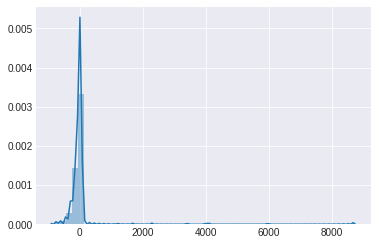

In [76]:
sns.distplot(adata.X.sum(1).A1*theta[:,9].X-ambcounts)

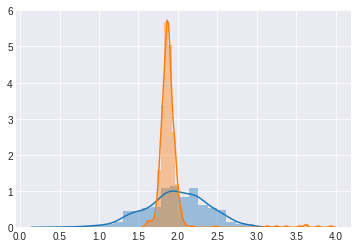

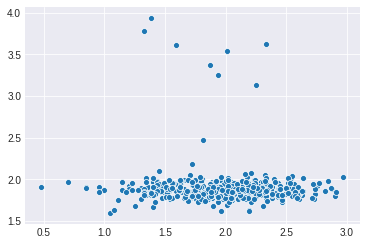

In [77]:
sns.distplot(np.log10(ambcounts))
sns.distplot(np.log10(adata.X.sum(1).A1*theta[:,9].X))
plt.show()
sns.scatterplot(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))

In [79]:
np.corrcoef(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))

array([[ 1.        , -0.05214897],
       [-0.05214897,  1.        ]])

1
1
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 5,191.1: 100%|██████████| 200/200 [00:45<00:00,  3.45it/s]
Finished [100%]: Average Loss = 5,142.8


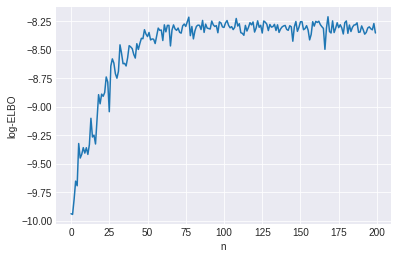

500it [00:09, 50.75it/s]


[[1.         0.78963589]
 [0.78963589 1.        ]]
137318.0


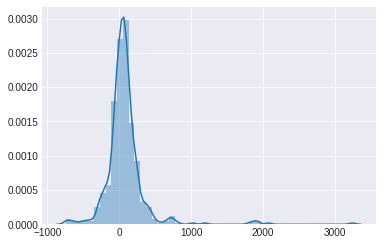

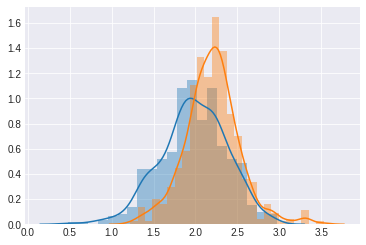

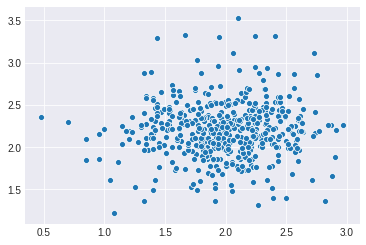

0.02866654460079135
1
100
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 5,316: 100%|██████████| 200/200 [00:46<00:00,  3.98it/s]
Finished [100%]: Average Loss = 5,272.1


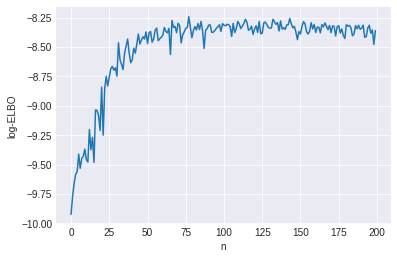

Trying to set attribute `.obs` of view, making a copy.
500it [00:10, 46.41it/s]


[[1.         0.76686671]
 [0.76686671 1.        ]]
133867.0


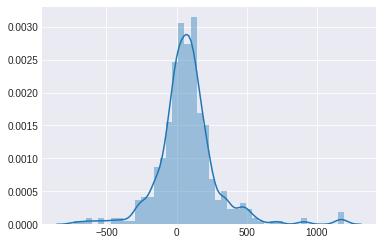

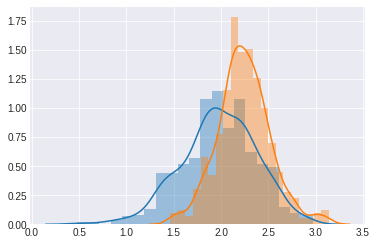

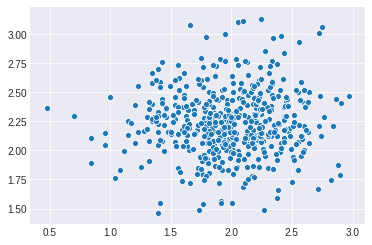

0.04787281591664887
1
10000
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 10,460: 100%|██████████| 200/200 [00:46<00:00,  4.64it/s]
Finished [100%]: Average Loss = 10,333


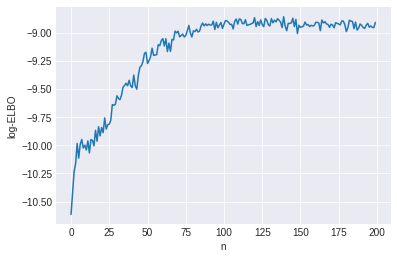

Trying to set attribute `.obs` of view, making a copy.
500it [00:08, 61.16it/s]


[[1.         0.79484886]
 [0.79484886 1.        ]]
95731.0


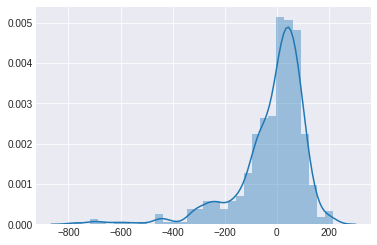

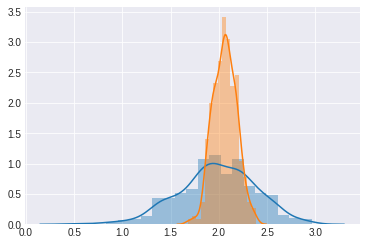

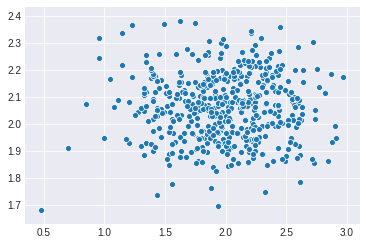

0.0035603029303618375
1
1000000
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 1.6089e+05: 100%|██████████| 200/200 [00:38<00:00,  5.33it/s]
Finished [100%]: Average Loss = 1.5465e+05


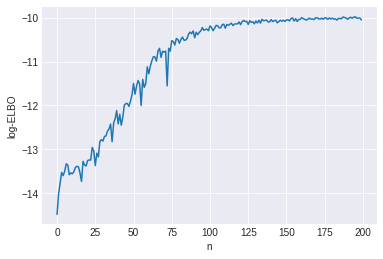

Trying to set attribute `.obs` of view, making a copy.
500it [00:09, 56.13it/s]


[[1.         0.79586055]
 [0.79586055 1.        ]]
89571.0


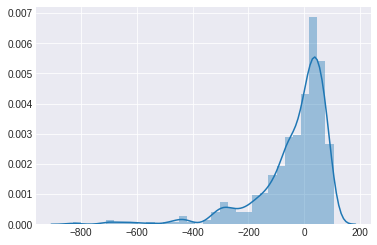

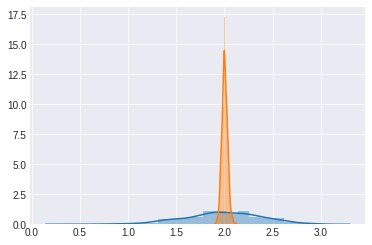

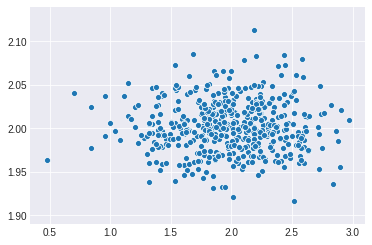

0.001494141694248429
100
1
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 5,803.1: 100%|██████████| 200/200 [00:33<00:00,  6.00it/s]
Finished [100%]: Average Loss = 5,759


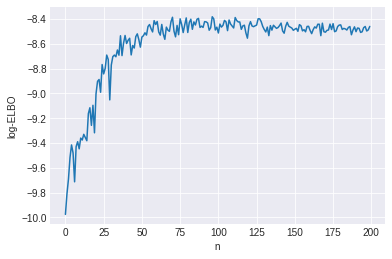

Trying to set attribute `.obs` of view, making a copy.
500it [00:08, 56.21it/s]


[[1.         0.82047148]
 [0.82047148 1.        ]]
141882.0


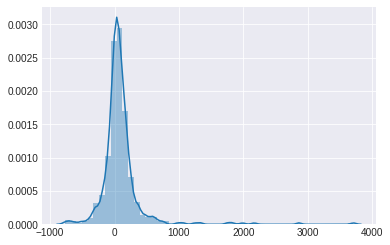

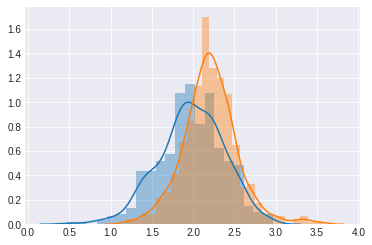

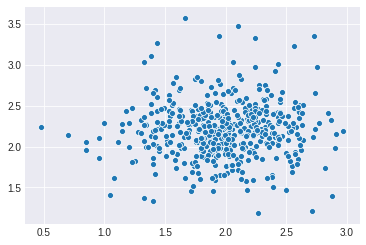

0.04642068927836734
100
100
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 5,979.8: 100%|██████████| 200/200 [00:41<00:00,  3.32it/s]
Finished [100%]: Average Loss = 5,934.6


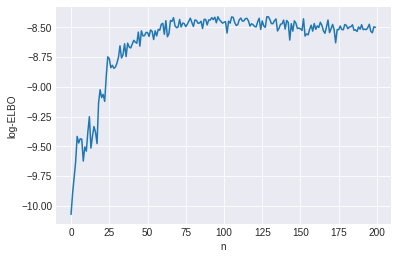

Trying to set attribute `.obs` of view, making a copy.
500it [00:09, 55.44it/s]


[[1.         0.80064688]
 [0.80064688 1.        ]]
137566.0


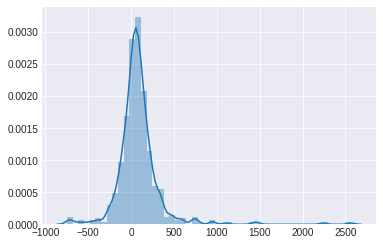

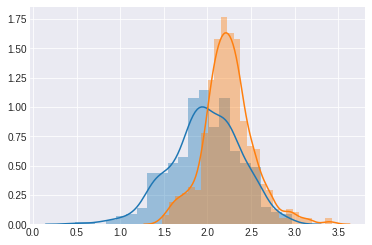

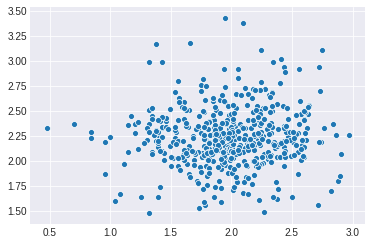

0.055743547298102596
100
10000
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 11,135: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]
Finished [100%]: Average Loss = 11,013


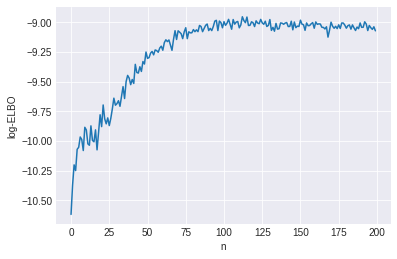

Trying to set attribute `.obs` of view, making a copy.
500it [00:10, 48.33it/s]


[[1.         0.78698927]
 [0.78698927 1.        ]]
96682.0


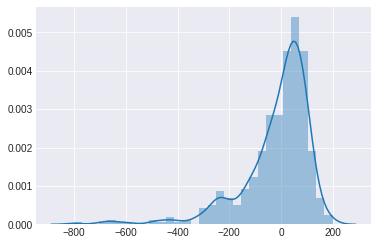

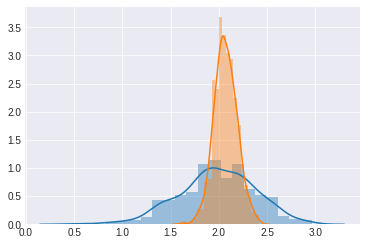

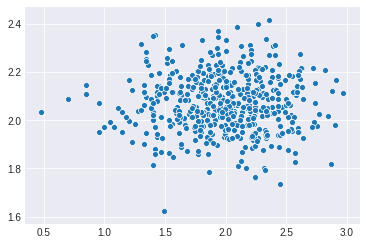

-0.0003985360099472923
100
1000000
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 1.554e+05: 100%|██████████| 200/200 [00:35<00:00,  5.51it/s]
Finished [100%]: Average Loss = 1.4943e+05


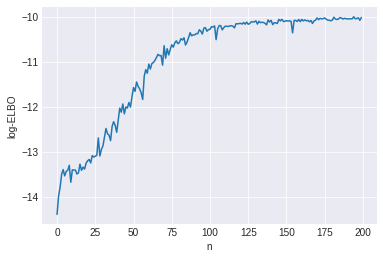

Trying to set attribute `.obs` of view, making a copy.
500it [00:09, 55.41it/s]


[[1.         0.79000688]
 [0.79000688 1.        ]]
89742.0


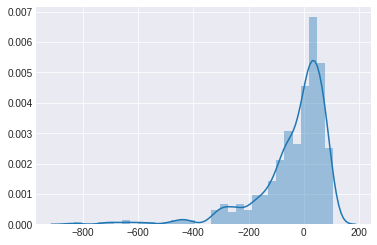

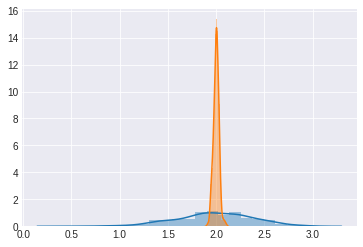

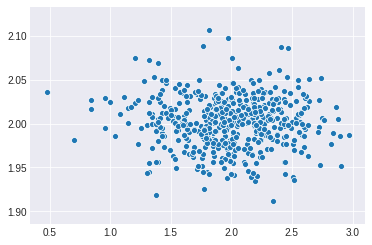

-0.02201848361628319
10000
1
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 66,348: 100%|██████████| 200/200 [00:36<00:00,  4.88it/s]
Finished [100%]: Average Loss = 66,280


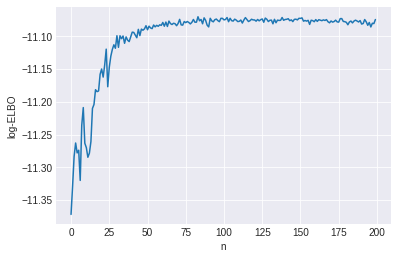

Trying to set attribute `.obs` of view, making a copy.
500it [00:11, 42.39it/s]


[[1.         0.81379513]
 [0.81379513 1.        ]]
209547.0


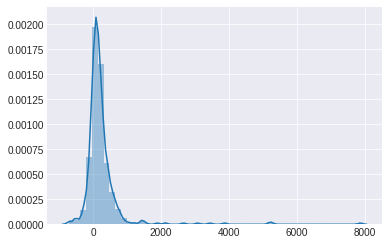

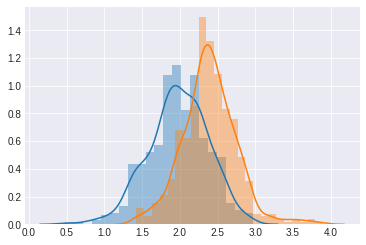

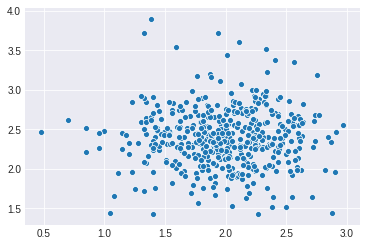

-0.007069416971437042
10000
100
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 66,555: 100%|██████████| 200/200 [00:38<00:00,  4.75it/s]
Finished [100%]: Average Loss = 66,479


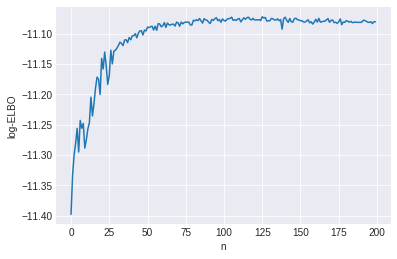

Trying to set attribute `.obs` of view, making a copy.
500it [00:11, 44.61it/s]


[[1.         0.81404035]
 [0.81404035 1.        ]]
201355.0


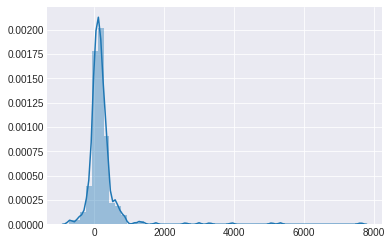

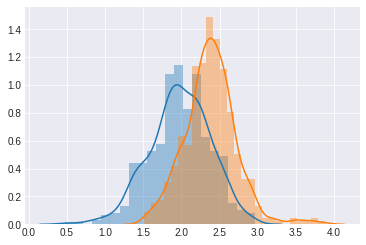

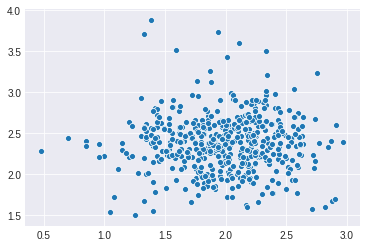

0.008045989635032882
10000
10000
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 71,859: 100%|██████████| 200/200 [19:07<00:00,  5.08it/s]
Finished [100%]: Average Loss = 71,701


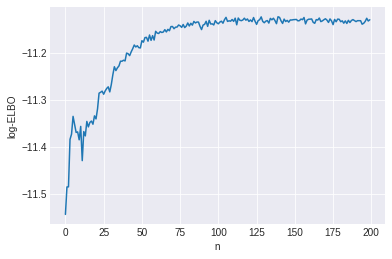

Trying to set attribute `.obs` of view, making a copy.
500it [00:08, 61.03it/s]


[[1.         0.73717199]
 [0.73717199 1.        ]]
106636.0


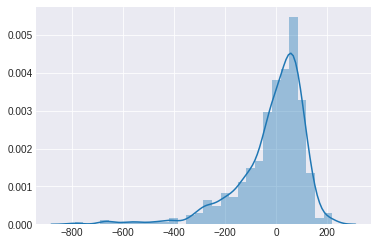

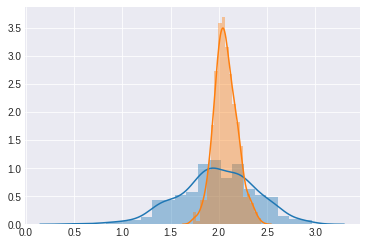

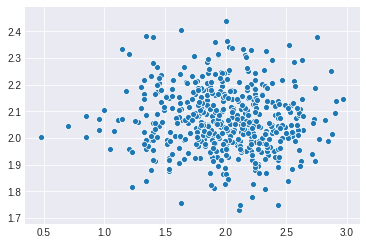

-0.05799951869299107
10000
1000000
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 2.1853e+05: 100%|██████████| 200/200 [00:32<00:00,  6.44it/s]
Finished [100%]: Average Loss = 2.1244e+05


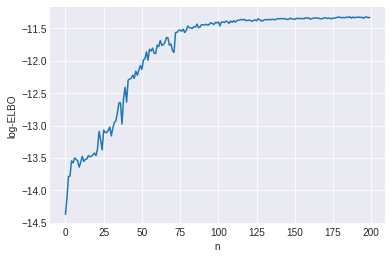

Trying to set attribute `.obs` of view, making a copy.
500it [00:07, 63.88it/s]


[[1.        0.7128728]
 [0.7128728 1.       ]]
99398.0


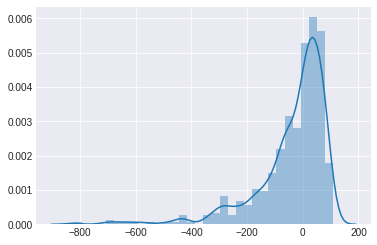

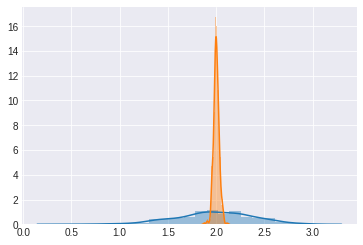

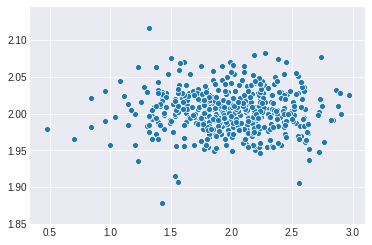

-0.00662312876183485
1000000
1
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 5.6336e+06: 100%|██████████| 200/200 [00:38<00:00,  5.36it/s]
Finished [100%]: Average Loss = 5.6291e+06


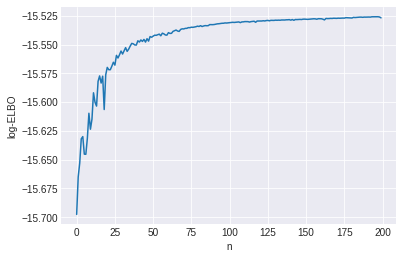

Trying to set attribute `.obs` of view, making a copy.
500it [00:07, 65.56it/s]


[[1.         0.56576769]
 [0.56576769 1.        ]]
110052.0


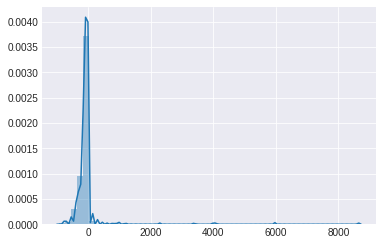

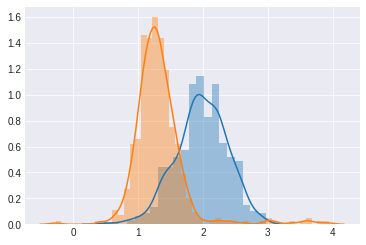

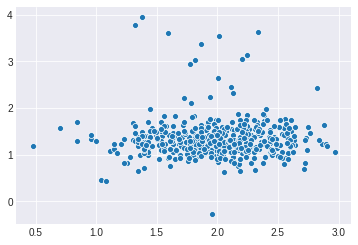

0.0021000571361059006
1000000
100
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 5.6245e+06: 100%|██████████| 200/200 [00:30<00:00,  6.40it/s]
Finished [100%]: Average Loss = 5.6204e+06


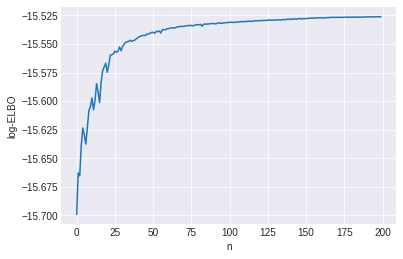

Trying to set attribute `.obs` of view, making a copy.
500it [00:07, 64.30it/s]


[[1.         0.61335728]
 [0.61335728 1.        ]]
115297.0


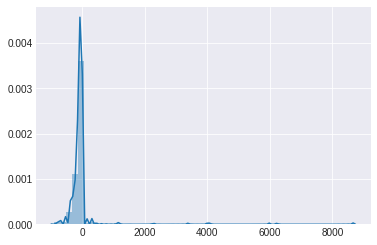

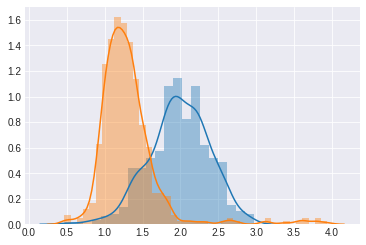

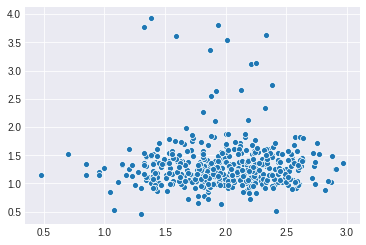

0.017122192313309283
1000000
10000
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 5.6533e+06: 100%|██████████| 200/200 [00:39<00:00,  4.85it/s]
Finished [100%]: Average Loss = 5.6486e+06


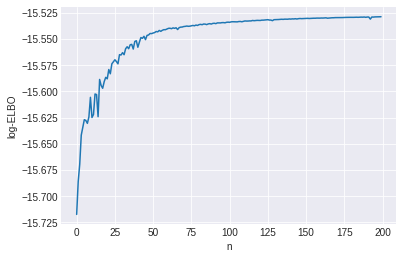

Trying to set attribute `.obs` of view, making a copy.
500it [00:10, 45.66it/s]


[[1.         0.63477896]
 [0.63477896 1.        ]]
131722.0


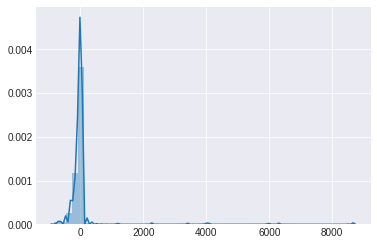

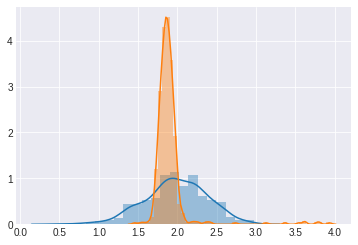

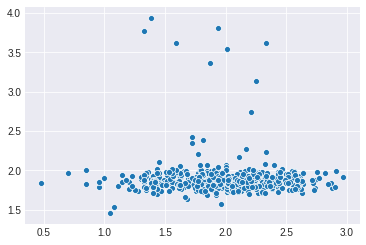

-0.03245534805982473
1000000
1000000
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822
l __str__ = -472708.8834348512
l __str__ = -7098749.47033822
l __str__ = -715.5246325548928
l __str__ = -8195396.47033822


Average Loss = 5.775e+06: 100%|██████████| 200/200 [00:33<00:00,  6.32it/s]
Finished [100%]: Average Loss = 5.764e+06


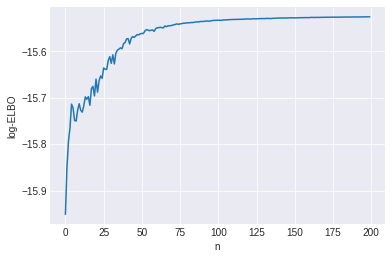

Trying to set attribute `.obs` of view, making a copy.
500it [00:08, 60.72it/s]


[[1.         0.69105427]
 [0.69105427 1.        ]]
104426.0


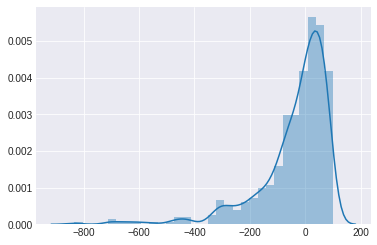

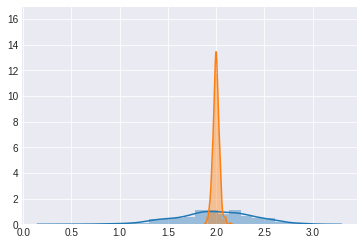

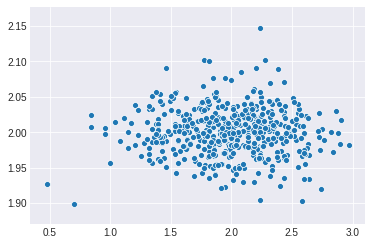

-0.010495318550325754


In [13]:
corrs=[]
diffs=[]
for ALPH in [1,100,10000,1000000]:
    for BET in [1,100,10000,1000000]:
        print(ALPH)
        print(BET)
        feature_names=list(adata.var.index)
        tf=adata.X
        n_tokens = np.sum(tf[tf.nonzero()])
        model1 = pm.Model()
        (D,V)=tf.shape
        alpha = np.ones((1, K))
        phi = np.ones((1, V))
        sparse_array=shared(np.array([tf.nonzero()[0],tf.nonzero()[1],tf.data]).T.astype('int32'))
        tt.cast(sparse_array,'int32')
        rowsums=shared(np.sum(tf,axis=1).T)
        sumall=shared(np.sum(tf))
        def lognormpdf(mean, sd):
            import math
            def internalnorm(x):
                var = float(sd)**2
                denom = tt.log(2*math.pi*var)*.5
                num = -(x-float(mean))**2/(2*var)
                return(num-denom)
            return internalnorm
        ambient=lognormpdf(ambmu,ambsd)

        def log_lda(theta, phi,value,rowsums,sumall,phiAmbient=None):
            if phiAmbient is not None:
                phi=tt.concatenate([phi,phiAmbient],axis=0)
            else:
                phi=phi
            ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-9)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-9),axis=1).ravel()                                                                  
            ambientll=ambient(tt.log10((rowsums+1e-9)*(theta[:,theta.shape[1]-1]+1e-9)))
            tt.printing.Print('l')(tt.sum(ambientll)*(sumall/rowsums.shape[1]))
            tt.printing.Print('l')(tt.sum(ll))
            tt.printing.Print('l')(tt.sum(ambientll)-rowsums.shape[1])
            tt.printing.Print('l')(tt.sum(ll)-sumall)
            #return tt.sum(ll) + tt.sum(ambientll)*(sumall/rowsums.shape[1])
            return (((ALPH*tt.sum(ll)/sumall) + (BET*tt.sum(ambientll)/ambientll.shape[1])))

        with model1: 
            theta = pm.Dirichlet("theta", a=alpha, shape=(D, K), transform=t_stick_breaking(1e-9)).astype('float32')
            phi = pm.Dirichlet("phi", a=phi, shape=(K-1, V), transform=t_stick_breaking(1e-9)).astype('float32')
            #ambient=from_epdf('ambient',ambient_counts)
            #doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta, phi=phi,ambient=ambient, value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))
            doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta,
                phi=phi,
                value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))

        eta = .3
        s = shared(eta)
        def reduce_rate(a, h, i):
            s.set_value(eta/(1+(i+1)/100)**.4)    

        with model1:    
            #inference = pm.ADVI()
            #inference = pm.FullRankADVI()
            inference=pm.variational.NFVI()
            approx = pm.fit(n=200,method= inference,obj_optimizer=pm.adam(learning_rate=s),callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])



        tr1 = approx.sample(draws=500)
        advi_elbo = pd.DataFrame(
            {'log-ELBO': -np.log(approx.hist),
             'n': np.arange(approx.hist.shape[0])})
        plt.clf()
        sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
        plt.show()
        plt.savefig(os.path.join(sc.settings.figdir,'ELBO.png'))
        theta=tr1['theta'].mean(0)

        theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
        for i in range(theta.shape[1]):
            freshadata.obs['lda_'+str(i)]=theta[:,i].X

        # In[15]:
        phi=tr1['phi'].mean(0)
        phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))

        for i in range(phi.shape[0]):
            freshadata.var['lda_'+str(i)]=0
            freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(i)]=phi[i,:][:,list(phiAmbientDict.keys())].X
        freshadata.var['lda_'+str(K-1)]=0
        #Resort indices so the ones we're subtracting from are listed first
        freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(K-1)]=list(phiAmbientDict.values())
        fullinds=list(freshadata.var.index)
        [fullinds.insert(0, fullinds.pop(fullinds.index(i))) for i in feature_names[::-1]]
        freshadata=freshadata[:,fullinds]
        #Reassign phiAmbient now that matrix is reordered
        phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))

        tmpmat3=scipy.sparse.csr_matrix(freshadata.shape)
        theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
        phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
        #txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
        for ci,c in tqdm(enumerate(freshadata.obs.index)):
            farow=freshadata[c,:].X
            rowinds=farow.nonzero()[0]
            countz=farow[rowinds]
            rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
            rowtxpamb=(theta[ci,(K-1)]*phi[:,(K-1)].T).A1
            indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
            vals = np.array([item for sublist in indmultiset for item in sublist])
            phimultiset=[[rowtxpamb[rowind]/countz[i]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
            pvals = np.array([item for sublist in phimultiset for item in sublist])
            phimultiset=[[rowtxp[rowind]+rowtxpamb[rowind]+1e-10]*int(countz[i]) for i,rowind in enumerate(rowinds)]
            pvalsdenom = np.array([item for sublist in phimultiset for item in sublist])
            pvals=pvals/(pvalsdenom)
            vals=vals[pvals>0]
            pvals=pvals[pvals>0]
            if len(vals)>0:
                #Select counts based on phiAmbient
                cellcount=np.sum(freshadata[c,:][:,feature_names].X)
                countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[ci,theta.shape[1]-1]*cellcount)),p=np.array(pvals)/sum(pvals))) 
                tmpmat3[ci,list(countremove.keys())]=list(countremove.values())


        theta=tr1['theta'].mean(0)
        theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
        # In[15]:
        phi=tr1['phi'].mean(0)
        phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
        #Reassign phiAmbient now that matrix is reordered
        phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
        #phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    



        theta=tr1['theta'].mean(0)
        theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
        # In[15]:
        phi=tr1['phi'].mean(0)
        phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
        #Reassign phiAmbient now that matrix is reordered
        phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
        #phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    



        print(np.corrcoef(phiAmbient, tmpmat3.sum(0)))
        print(np.absolute(tmpmat-tmpmat3).sum())
        diffs.append(np.absolute(tmpmat-tmpmat3).sum())


        sns.distplot(adata.X.sum(1).A1*theta[:,9].X-ambcounts)
        plt.show()
        sns.distplot(np.log10(ambcounts))
        sns.distplot(np.log10(adata.X.sum(1).A1*theta[:,9].X))
        plt.show()
        sns.scatterplot(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))
        plt.show()
        corrs.append(np.corrcoef(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))[0,1])
        print(np.corrcoef(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))[0,1])

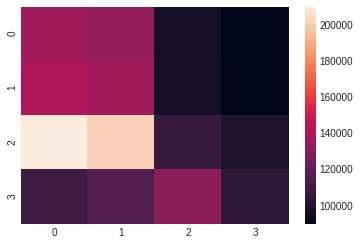

In [14]:
sns.heatmap(np.array(diffs).reshape(4,4))

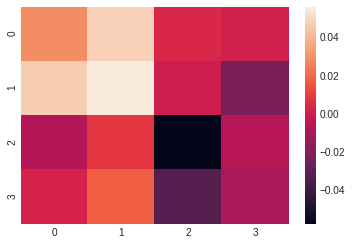

In [15]:
sns.heatmap(np.array(corrs).reshape(4,4))

In [24]:
np.array(range(16)).reshape(4,4)      

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [43]:
#sc.pp.filter_genes(freshadata,min_counts=2,inplace=True)
sc.pp.filter_cells(freshadata,min_counts=500,inplace=True)
sc.pp.normalize_total(freshadata, target_sum=1e4)
sc.pp.log1p(freshadata)
sc.pp.highly_variable_genes(freshadata,n_top_genes=min(adata.shape[1],4000),inplace=True)
sc.pp.scale(freshadata, max_value=10)
sc.pp.pca(freshadata)
sc.pp.neighbors(freshadata)
sc.tl.umap(freshadata)
sc.tl.leiden(freshadata)
sc.pl.umap(freshadata, color=['leiden'],save="AfterLeiden")

sc.pl.umap(freshadata, color=['lda_0','lda_1','lda_2','lda_3','lda_4','lda_5','lda_6','lda_7','lda_8','lda_9','n_counts'],save="AfterLDA")

500it [00:10, 49.22it/s]


In [160]:
maxgenes=1000
ncells=500
headpath=os.path.expanduser("/home/mt/Downloads/")
adata=sc.read_h5ad(os.path.join(headpath,'MultiseqRaw.h5ad'))
adata._inplace_subset_obs(adata.obs['batch']=='0')
cells=np.random.choice(adata.obs.index,ncells,replace=False)
sc.pp.filter_cells(adata,min_counts=15,inplace=True)
adata._inplace_subset_obs(cells)
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=min(maxgenes,4000))
sc.pp.scale(adata, max_value=10)
#sc.pp.regress_out(adata,'n_counts')

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
clusters=adata.obs['leiden']

In [161]:
headpath=os.path.expanduser("/home/mt/Downloads/")
adata=sc.read_h5ad(os.path.join(headpath,'MultiseqRaw.h5ad'))
adata._inplace_subset_obs(cells)
adata._inplace_subset_var((-adata.X).sum(0).A1.argsort()[0:min(maxgenes,adata.shape[1])])
adata.obs['leiden']=clusters
freshadata=adata.copy()

In [162]:
ambmu,ambsd=2.0,.4
K=10
n_iterations=120

In [163]:
clusterphis=[]
for c in set(clusters):
    clusterphis.append(adata[adata.obs['leiden']==c,:].X.sum(0).A1)
clusterphis=np.matrix(clusterphis)
clusterphis=clusterphis/(clusterphis.sum(1))

def Stick_Breaking(num_weights, alpha):
    betas = np.random.beta(1, alpha, size=num_weights)
    betas[1:] *= np.cumprod(1 - betas[:-1])
    return betas
ambprops=Stick_Breaking(len(set(clusters)),1)
ambcounts=[int(x) for x in 10**np.random.normal(ambmu,ambsd,adata.shape[0])]
print(ambprops)
sum(ambprops)


[0.07868262 0.19267869 0.16338414 0.19150957 0.22539099 0.06401751
 0.01165545 0.0310416  0.0308553 ]


0.989215886534669

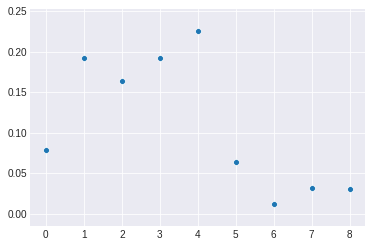

In [164]:
sns.scatterplot(list(range(len(ambprops))),ambprops)

In [165]:
phiAmbient=(ambprops*clusterphis).A1
phiAmbient=phiAmbient/phiAmbient.sum()
phiAmbientDict=dict(zip(list(adata.var.index), phiAmbient))
tmpmat=scipy.sparse.csr_matrix(adata.shape)
for ci,c in tqdm(enumerate(adata.obs.index)):
    countremove=Counter(np.random.choice(list(range(len(phiAmbient))),replace=True,size=ambcounts[ci],p=phiAmbient))
    tmpmat[ci,list(countremove.keys())]=list(countremove.values())

500it [00:00, 760.75it/s]


In [166]:
adata.X.sum()

1074145.0

In [167]:
adata.X=adata.X+tmpmat

In [168]:
adata.X.sum()

1156242.0

In [169]:
np.corrcoef(tmpmat.sum(0).A1,phiAmbient)

array([[1.        , 0.99978386],
       [0.99978386, 1.        ]])

In [170]:
feature_names=list(adata.var.index)
tf=adata.X
n_tokens = np.sum(tf[tf.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(tf.nonzero()[0]) / float(tf.shape[0] * tf.shape[1])))

model1 = pm.Model()
(D,V)=tf.shape
print(D,V)
alpha = np.ones((1, K))
phi = np.ones((1, V))
sparse_array=shared(np.array([tf.nonzero()[0],tf.nonzero()[1],tf.data]).T.astype('int32'))
tt.cast(sparse_array,'int32')
rowsums=shared(np.sum(tf,axis=1).T)
sumall=shared(np.sum(tf))
def lognormpdf(mean, sd):
    import math
    def internalnorm(x):
        var = float(sd)**2
        denom = tt.log(2*math.pi*var)*.5
        num = -(x-float(mean))**2/(2*var)
        return(num-denom)
    return internalnorm
ambient=lognormpdf(ambmu,ambsd)

def log_lda(theta, phi,value,rowsums,sumall,phiAmbient=None):
    if phiAmbient is not None:
        phi=tt.concatenate([phi,phiAmbient],axis=0)
    else:
        phi=phi
    ll = value[:,2] * pm.math.logsumexp(tt.log(theta[value[:,0].astype('int32')]+1e-9)+ tt.log(phi.T[value[:,1].astype('int32')]+1e-9),axis=1).ravel()                                                                  
    ambientll=ambient(tt.log10((rowsums+1e-9)*(theta[:,theta.shape[1]-1]+1e-9)))
    tt.printing.Print('l')(tt.sum(ambientll)*(sumall/rowsums.shape[1]))
    tt.printing.Print('l')(tt.sum(ll))
    tt.printing.Print('l')(tt.sum(ambientll)-rowsums.shape[1])
    tt.printing.Print('l')(tt.sum(ll)-sumall)
    #return tt.sum(ll) + tt.sum(ambientll)*(sumall/rowsums.shape[1])
    return (tt.sum(ll)-sumall) + (tt.sum(ambientll)-rowsums.shape[1])

with model1: 
    theta = pm.Dirichlet("theta", a=alpha, shape=(D, K), transform=t_stick_breaking(1e-9)).astype('float32')
    phi = pm.Dirichlet("phi", a=phi, shape=(K-1, V), transform=t_stick_breaking(1e-9)).astype('float32')
    #ambient=from_epdf('ambient',ambient_counts)
    #doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta, phi=phi,ambient=ambient, value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))
    doc = pm.DensityDist('doc', log_lda, observed=dict(theta=theta,
        phi=phi,
        value=sparse_array,phiAmbient=np.matrix([phiAmbientDict[x] for x in feature_names]),rowsums=rowsums,sumall=sumall))

eta = .3
s = shared(eta)
def reduce_rate(a, h, i):
    s.set_value(eta/((i/10)+1)**.4)    

Number of tokens in training set = 1156242.0
Sparsity = 0.523124
500 1000
l __str__ = -534138.2328659354
l __str__ = -7471625.511612547
l __str__ = -730.9802934272996
l __str__ = -8627867.511612546
l __str__ = -534138.2328659354
l __str__ = -7471625.511612547
l __str__ = -730.9802934272996
l __str__ = -8627867.511612546
l __str__ = -534138.2328659354
l __str__ = -7471625.511612547
l __str__ = -730.9802934272996
l __str__ = -8627867.511612546


In [171]:
with model1:    
    #inference = pm.ADVI()
    #inference = pm.FullRankADVI()
    inference=pm.variational.NFVI()
    approx = pm.fit(n=200,method= inference,obj_optimizer=pm.adam(learning_rate=s),callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')])


Average Loss = 7.7231e+06: 100%|██████████| 200/200 [00:35<00:00,  5.91it/s]
Finished [100%]: Average Loss = 7.7187e+06


[[1.        0.2542435]
 [0.2542435 1.       ]]


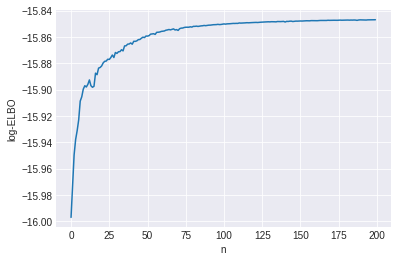

In [172]:

tr1 = approx.sample(draws=1000)
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(approx.hist),
     'n': np.arange(approx.hist.shape[0])})
plt.clf()
sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)
plt.savefig(os.path.join(sc.settings.figdir,'ELBO.png'))
theta=tr1['theta'].mean(0)
print(np.corrcoef(adata.X.sum(1).A1*theta[:,9],ambcounts))

theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
for i in range(theta.shape[1]):
    freshadata.obs['lda_'+str(i)]=theta[:,i].X

# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))

for i in range(phi.shape[0]):
    freshadata.var['lda_'+str(i)]=0
    freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(i)]=phi[i,:][:,list(phiAmbientDict.keys())].X
freshadata.var['lda_'+str(K-1)]=0
#Resort indices so the ones we're subtracting from are listed first
freshadata.var.loc[list(phiAmbientDict.keys()),'lda_'+str(K-1)]=list(phiAmbientDict.values())
fullinds=list(freshadata.var.index)
[fullinds.insert(0, fullinds.pop(fullinds.index(i))) for i in feature_names[::-1]]
freshadata=freshadata[:,fullinds]
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))

In [173]:
tmpmat3=scipy.sparse.csr_matrix(freshadata.shape)
theta=np.matrix(freshadata.obs.loc[:,['lda' in x for x in freshadata.obs.columns]])
phi=np.matrix(freshadata.var.loc[:,['lda' in x for x in freshadata.var.columns]])
#txp=theta[:,0:(K-1)]*phi[:,0:(K-1)].T
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rowtxp=(theta[ci,0:(K-1)]*phi[:,0:(K-1)].T).A1 #memory saving #txp[ci,:].A1
    rowtxpamb=(theta[ci,(K-1)]*phi[:,(K-1)].T).A1
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = np.array([item for sublist in indmultiset for item in sublist])
    phimultiset=[[rowtxpamb[rowind]/countz[i]]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvals = np.array([item for sublist in phimultiset for item in sublist])
    phimultiset=[[rowtxp[rowind]+rowtxpamb[rowind]+1e-10]*int(countz[i]) for i,rowind in enumerate(rowinds)]
    pvalsdenom = np.array([item for sublist in phimultiset for item in sublist])
    pvals=pvals/(pvalsdenom)
    vals=vals[pvals>0]
    pvals=pvals[pvals>0]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[ci,theta.shape[1]-1]*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat3[ci,list(countremove.keys())]=list(countremove.values())


500it [00:09, 58.31it/s]


In [174]:
theta=tr1['theta'].mean(0)
theta=anndata.AnnData(theta,var=pd.DataFrame(index=['lda_'+str(i) for i in range(K) ]),obs=pd.DataFrame(index=list(adata.obs.index)))
# In[15]:
phi=tr1['phi'].mean(0)
phi=anndata.AnnData(phi,var=pd.DataFrame(index=feature_names),obs=pd.DataFrame(index=['lda_'+str(i) for i in range(K-1) ]))
#Reassign phiAmbient now that matrix is reordered
phiAmbientDict=dict(zip(list(freshadata.var.index),list(freshadata.var['lda_'+str(K-1)])))
#phiAmbient=np.array(freshadata.var['lda_'+str(K-1)])    

tmpmat2=scipy.sparse.csr_matrix(freshadata.shape)
for ci,c in tqdm(enumerate(freshadata.obs.index)):
    farow=freshadata[c,:].X
    rowinds=farow.nonzero()[0]
    countz=farow[rowinds]
    rownames=freshadata.var.index[rowinds]
    indmultiset=[[rowinds[i]]*int(countz[i]) for i in range(len(countz))]
    vals = [item for sublist in indmultiset for item in sublist]
    #phimultiset=[[phiAmbientDict[rowname]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    phimultiset=[[phiAmbientDict[rowname]/countz[i]]*int(countz[i]) for i,rowname in enumerate(rownames)]
    pvals = [item for sublist in phimultiset for item in sublist]
    if len(vals)>0:
        #Select counts based on phiAmbient
        cellcount=np.sum(freshadata[c,:][:,feature_names].X)
        countremove=Counter(np.random.choice(vals,replace=False,size=min(len(vals),int(theta[c,theta.shape[1]-1].X*cellcount)),p=np.array(pvals)/sum(pvals))) 
        tmpmat2[ci,list(countremove.keys())]=list(countremove.values())


500it [00:09, 54.61it/s]


In [175]:
print(np.corrcoef(phiAmbient, tmpmat3.sum(0)))
print(np.corrcoef(phiAmbient, tmpmat2.sum(0)))
(tmpmat-tmpmat3).sum()

[[1.         0.87702186]
 [0.87702186 1.        ]]
[[1.         0.93499451]
 [0.93499451 1.        ]]


-26810.0

In [176]:
print(np.absolute(tmpmat-tmpmat2).sum())
print(np.absolute(tmpmat-tmpmat3).sum())
print(np.absolute(tmpmat-tmpmat3).sum(0))
print(np.absolute(tmpmat.sum()))


141116.0
162960.0
[[3.5360e+03 3.4480e+03 4.1293e+04 1.6670e+03 1.2460e+03 1.1850e+03
  1.2070e+03 8.5300e+02 6.9000e+02 6.2900e+02 5.4700e+02 5.3700e+02
  5.4400e+02 5.0700e+02 1.0429e+04 4.6800e+02 4.0600e+02 4.7800e+02
  3.7400e+02 4.0400e+02 3.8400e+02 7.5560e+03 3.6600e+02 3.4300e+02
  3.2300e+02 3.6500e+02 3.0300e+02 3.2900e+02 2.8800e+02 3.1100e+02
  3.3100e+02 2.9600e+02 3.2400e+02 3.0500e+02 3.3200e+02 3.0700e+02
  2.8400e+02 2.8700e+02 3.1000e+02 3.0700e+02 2.7700e+02 2.7100e+02
  4.8300e+02 2.7600e+02 2.9300e+02 2.6100e+02 3.1500e+02 2.7900e+02
  2.6500e+02 3.3300e+02 2.4000e+02 2.6100e+02 2.4600e+02 2.5400e+02
  2.4500e+02 2.6100e+02 2.2200e+02 2.3800e+02 2.2600e+02 2.6300e+02
  2.6000e+02 2.2300e+02 2.2800e+02 2.7100e+02 2.4000e+02 2.5300e+02
  2.4800e+02 2.2300e+02 1.9700e+02 2.2700e+02 2.1800e+02 2.2500e+02
  2.2400e+02 2.2800e+02 2.2600e+02 2.4900e+02 2.1000e+02 2.2800e+02
  2.4500e+02 2.1500e+02 2.0500e+02 1.9600e+02 2.1900e+02 1.9800e+02
  2.2400e+02 2.0000e+02 2.1200

In [177]:
np.corrcoef(adata.X.sum(1).A1*theta[:,9].X,ambcounts)

array([[1.       , 0.2542435],
       [0.2542435, 1.       ]])

In [178]:
adata.X.sum(1).A1*theta[:,9].X

ArrayView([  205.59538671,   153.36550868,    18.47823457,   215.24476722,
             262.26940481,   103.2580009 ,    22.70603621,   115.91922126,
             210.05072482,    40.99374538,    72.04458154,   301.3791461 ,
             115.64193216,    75.45029281,    31.07024454,   148.80693269,
            6933.95149469,   277.74004269,   125.79348583,   122.48460738,
              68.92085819,   129.43483086,    90.19578807,  2421.51405722,
             770.42443228,    23.56463782,    95.81886788,    32.71030772,
              42.52644083,   187.15171996,    30.00186741,   517.08613068,
              64.4347399 ,   266.81843343,    73.79851341,    56.35447307,
              46.25090073,   107.62001261,   541.80062699,    72.50213481,
              35.91687282,   209.95966652,    35.90997723,   110.05318084,
              51.43158376,    64.45826203,   350.74969433,    70.23293105,
              34.92126744,    80.70931404,    93.86303549,   131.59233204,
              42.33592574

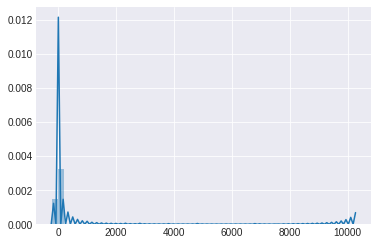

In [179]:
sns.distplot(adata.X.sum(1).A1*theta[:,9].X-ambcounts)

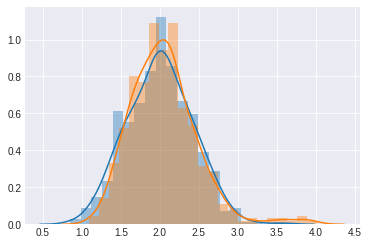

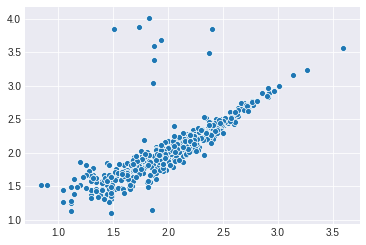

In [180]:
sns.distplot(np.log10(ambcounts))
sns.distplot(np.log10(adata.X.sum(1).A1*theta[:,9].X))
plt.show()
sns.scatterplot(np.log10(ambcounts),np.log10(adata.X.sum(1).A1*theta[:,9].X))

In [181]:
adata.X.sum(1).A1*theta[:,9].X

ArrayView([  205.59538671,   153.36550868,    18.47823457,   215.24476722,
             262.26940481,   103.2580009 ,    22.70603621,   115.91922126,
             210.05072482,    40.99374538,    72.04458154,   301.3791461 ,
             115.64193216,    75.45029281,    31.07024454,   148.80693269,
            6933.95149469,   277.74004269,   125.79348583,   122.48460738,
              68.92085819,   129.43483086,    90.19578807,  2421.51405722,
             770.42443228,    23.56463782,    95.81886788,    32.71030772,
              42.52644083,   187.15171996,    30.00186741,   517.08613068,
              64.4347399 ,   266.81843343,    73.79851341,    56.35447307,
              46.25090073,   107.62001261,   541.80062699,    72.50213481,
              35.91687282,   209.95966652,    35.90997723,   110.05318084,
              51.43158376,    64.45826203,   350.74969433,    70.23293105,
              34.92126744,    80.70931404,    93.86303549,   131.59233204,
              42.33592574

Trying to set attribute `.obs` of view, making a copy.


saving figure to file ./figures/umapAfterLeiden.pdf


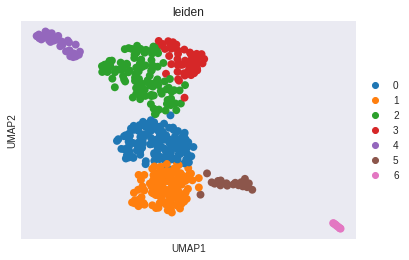

saving figure to file ./figures/umapAfterLDA.pdf


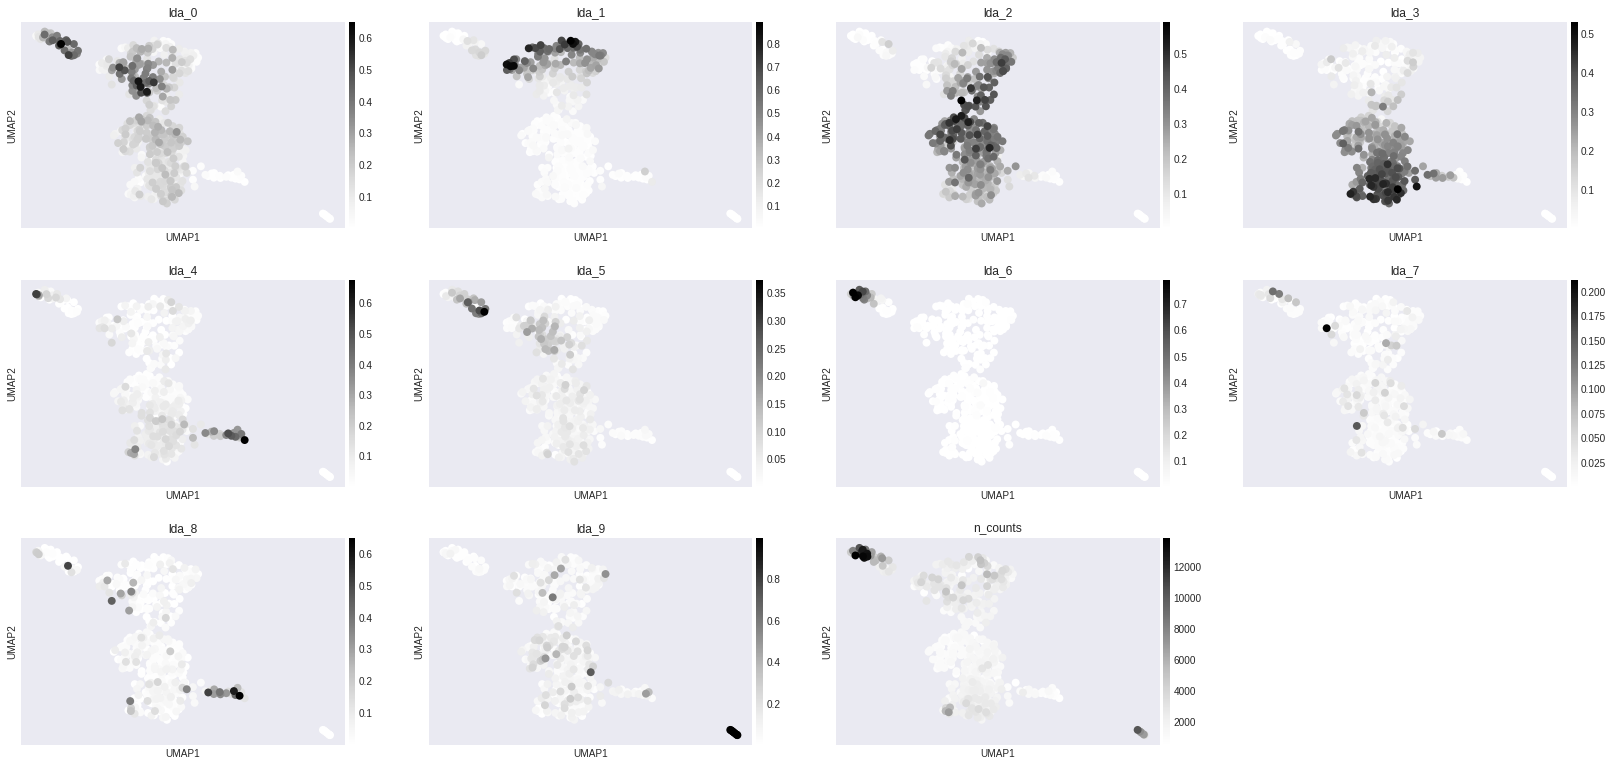

In [182]:

#sc.pp.filter_genes(freshadata,min_counts=2,inplace=True)
sc.pp.filter_cells(freshadata,min_counts=500,inplace=True)
sc.pp.normalize_total(freshadata, target_sum=1e4)
sc.pp.log1p(freshadata)
sc.pp.highly_variable_genes(freshadata,n_top_genes=min(adata.shape[1],4000),inplace=True)
sc.pp.scale(freshadata, max_value=10)
sc.pp.pca(freshadata)
sc.pp.neighbors(freshadata)
sc.tl.umap(freshadata)
sc.tl.leiden(freshadata)
sc.pl.umap(freshadata, color=['leiden'],save="AfterLeiden")

sc.pl.umap(freshadata, color=['lda_0','lda_1','lda_2','lda_3','lda_4','lda_5','lda_6','lda_7','lda_8','lda_9','n_counts'],save="AfterLDA")